## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Oct 20 10:02:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cdavumbk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cdavumbk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=c2ac2e27502d8f0b616f487f8c1f21e8b0a1a720d24405fbb2336e2de1eda5bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-v1e2g8xy/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 1.6 MB/s eta 0:00:00


## Imports

In [5]:
import os
import cv2
import torch

import supervision as sv

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

### Download SAM weights

In [6]:
!mkdir -p {HOME}/weights
!wget -q -P {HOME}/weights https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [7]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [8]:
!mkdir -p {HOME}/data

!wget -q -P {HOME}/data https://media.roboflow.com/kitchen.jpg

## Load Model

In [9]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

## Generate masks with SAM

In [10]:
IMAGE_PATH = os.path.join(HOME, "data", "kitchen.jpg")
MIN_AREA_PERCENTAGE = 0.005
MAX_AREA_PERCENTAGE = 0.05

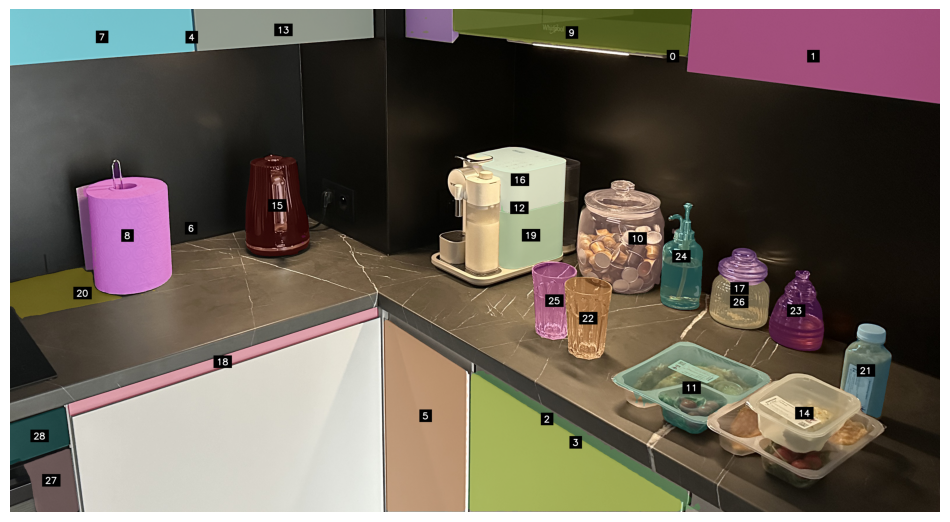

In [12]:
# load image
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# segment image
sam_result = mask_generator.generate(image_rgb)
detections = sv.Detections.from_sam(sam_result=sam_result)

# filter masks
height, width, channels = image_bgr.shape
image_area = height * width

min_area_mask = (detections.area / image_area) > MIN_AREA_PERCENTAGE
max_area_mask = (detections.area / image_area) < MAX_AREA_PERCENTAGE
detections = detections[min_area_mask & max_area_mask]

# setup annotators
mask_annotator = sv.MaskAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    opacity=0.3
)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER,
    text_scale=1,
    text_color=sv.Color.white(),
    color=sv.Color.black(),
    text_thickness=2
)

# annotate
labels = [str(i) for i in range(len(detections))]

annotated_image = mask_annotator.annotate(
    scene=image_bgr.copy(), detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(annotated_image)